In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from basis.src.basis import BasalIceStratigrapher
from basis.src.tvd_advection import AdvectTVD

In [2]:
# Initialize the model
BIS = BasalIceStratigrapher()
BIS.initialize('./experiments/static-effective-pressure/input_file.toml')

basal_water_pressure = 0.9 * (
    BIS.grid.at_node['ice_thickness'] * BIS.params['ice_density'] * BIS.params['gravity']
)
BIS.set_value('basal_water_pressure', basal_water_pressure)

BIS.set_value('sliding_velocity_y', BIS.grid.at_node['sliding_velocity_y'][:] * -1)

BIS.calc_effective_pressure()
BIS.calc_shear_stress()
BIS.calc_erosion_rate()
BIS.calc_melt_rate()

# Identify terminus nodes
dx = BIS.grid.dx
dy = BIS.grid.dy
bounds = [50 * dx, 100 * dx, 0 * dy, 15 * dy]
BIS.identify_terminus(bounds)

# Start with initial sediment package
initial_till = np.full(BIS.grid.number_of_nodes, 40)
BIS.set_value('till_thickness', initial_till)

initial_fringe = np.full(BIS.grid.number_of_nodes, 1e-3)
BIS.set_value('fringe_thickness', initial_fringe)

initial_dispersed = np.full(BIS.grid.number_of_nodes, 1e-9)
BIS.set_value('dispersed_layer_thickness', initial_dispersed)

In [3]:
# Spin-up the sediment entrainment module
for t in range(100):
    BIS.entrain_sediment(t * 1e-2)

for t in range(100):
    BIS.entrain_sediment(t)

for t in range(100):
    BIS.entrain_sediment(100)
    BIS.time_elapsed += 100

for t in range(2500):
    dt = BIS.sec_per_a / 100
    BIS.entrain_sediment(dt)
    BIS.time_elapsed += dt

    if t % 100 == 0:
        print('Completed step #' + str(t))

print('Completed spin-up: ' + str(np.round(BIS.time_elapsed / BIS.sec_per_a, 2)) + ' years elapsed.')

Qf, Qd = BIS.calc_sediment_flux()
print('Qf = ' + str(Qf * BIS.sec_per_a))
print('Qd = ' + str(Qd * BIS.sec_per_a))

Completed step #0
Completed step #100
Completed step #200
Completed step #300
Completed step #400
Completed step #500
Completed step #600
Completed step #700
Completed step #800
Completed step #900
Completed step #1000
Completed step #1100
Completed step #1200
Completed step #1300
Completed step #1400
Completed step #1500
Completed step #1600
Completed step #1700
Completed step #1800
Completed step #1900
Completed step #2000
Completed step #2100
Completed step #2200
Completed step #2300
Completed step #2400
Completed spin-up: 25.0 years elapsed.
Qf = 0.0047578543096
Qd = 37.1414121788


In [4]:
ux = BIS.grid.map_mean_of_link_nodes_to_link('sliding_velocity_x')
uy = BIS.grid.map_mean_of_link_nodes_to_link('sliding_velocity_y')

velocity = np.zeros(BIS.grid.number_of_links)

velocity = np.where(
    np.isin(np.arange(BIS.grid.number_of_links), BIS.grid.horizontal_links),
    ux,
    uy
)

BIS.grid.add_field('velocity_links', velocity, at = 'link', clobber = True)

TVD = AdvectTVD(BIS.grid, 'fringe_thickness', 'velocity_links')

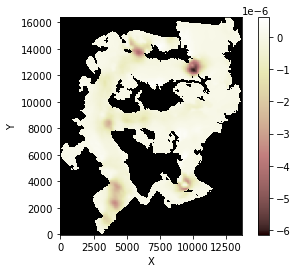

In [5]:
imshow_grid(BIS.grid, BIS.grid.map_mean_of_links_to_node('velocity_links'))

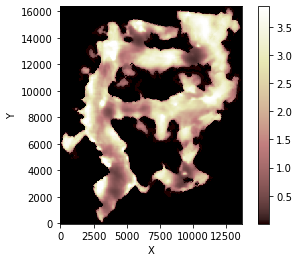

In [6]:
fringe0 = BIS.grid.at_node['fringe_thickness'][:].copy()
imshow_grid(BIS.grid, 'fringe_thickness')

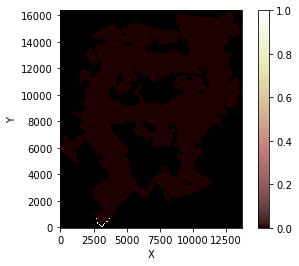

In [7]:
imshow_grid(BIS.grid, 'is_terminus')

In [8]:
print((len(BIS.east_boundary) + len(BIS.north_boundary) + len(BIS.west_boundary) + len(BIS.south_boundary)) * 50.0)
print(np.mean(BIS.grid.at_node['sliding_velocity_x'][BIS.east_boundary] * BIS.sec_per_a))
# print(np.mean(BIS.grid.at_node['sliding_velocity_x'][BIS.north_boundary] * BIS.sec_per_a))
print(np.mean(BIS.grid.at_node['sliding_velocity_x'][BIS.west_boundary] * BIS.sec_per_a))
print(np.mean(BIS.grid.at_node['sliding_velocity_x'][BIS.south_boundary] * BIS.sec_per_a))

1400.0
0.590685821391
-0.0649970006105
-2.78421342502


In [9]:
courant = TVD.calc_courant(TVD._grid, TVD._vel, 1e5)
np.max(np.abs(courant))

0.021702513549826108

Year 0 completed.


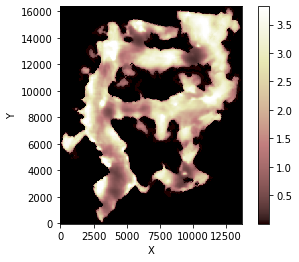

Year 50 completed.


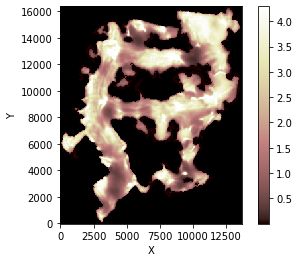

Year 100 completed.


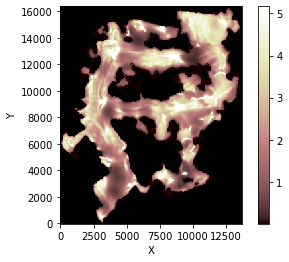

Year 150 completed.


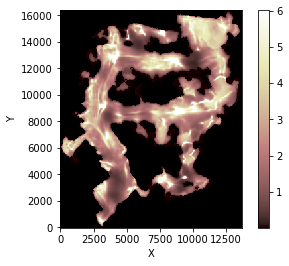

Year 200 completed.


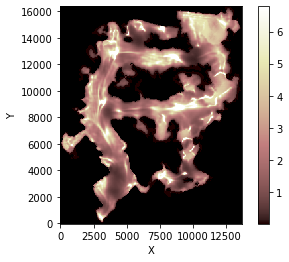

KeyboardInterrupt: 

In [10]:
dt = 1e5
year = 0
nyears = 100

for i in range(int(BIS.sec_per_a / dt) * nyears):
    TVD.update(dt)
    BIS.run_one_step(dt, erode = False, advect = False)
    
    fringe = BIS.grid.at_node['fringe_thickness']
    cutoff = np.percentile(fringe, 99)
    fringe[:] = np.where(
        fringe > cutoff,
        cutoff,
        fringe
    )
        
    if i % (int(BIS.sec_per_a / dt) * 10) == 0:
        print('Year ' + str(year) + ' completed.')
        year += 10
        
        imshow_grid(BIS.grid, 'fringe_thickness')
        plt.show()

Qf = 0.339719697244
Qd = 107.852754933


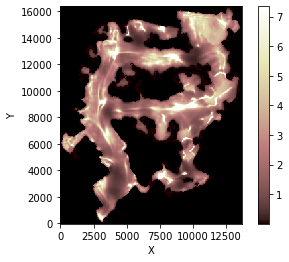

In [11]:
Qf, Qd = BIS.calc_sediment_flux()
print('Qf = ' + str(Qf * BIS.sec_per_a))
print('Qd = ' + str(Qd * BIS.sec_per_a))

imshow_grid(BIS.grid, 'fringe_thickness')

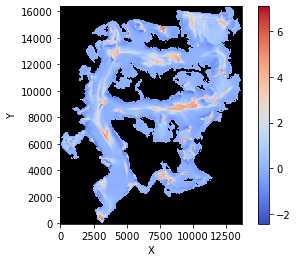

In [12]:
imshow_grid(
    BIS.grid, 
    BIS.grid.at_node['fringe_thickness'][:] - fringe0, 
    cmap = 'coolwarm',
    norm = TwoSlopeNorm(vcenter = 0)
)

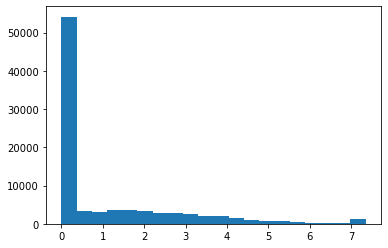

In [13]:
plt.hist(BIS.grid.at_node['fringe_thickness'][:], bins = 20)
plt.show()

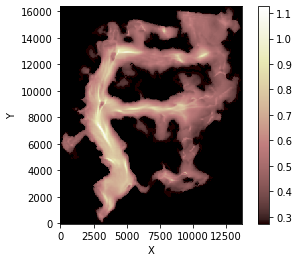

In [14]:
imshow_grid(BIS.grid, 'dispersed_layer_thickness')